In [50]:
import pandas as pd 
import numpy as np 
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split , GridSearchCV 
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import SMOTE


In [2]:
df = pd.read_csv("pima_indians_diabetes.csv")

In [3]:
df 

,time_pregnant_no,plasma_concentration,diastolic_blood_pressure,triceps_skinfold_thickness,serum_insulin,bmi,diabetes_pedigree,age,class
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   time_pregnant_no            768 non-null    int64  
 1   plasma_concentration        768 non-null    int64  
 2   diastolic_blood_pressure    768 non-null    int64  
 3   triceps_skinfold_thickness  768 non-null    int64  
 4   serum_insulin               768 non-null    int64  
 5   bmi                         768 non-null    float64
 6   diabetes_pedigree           768 non-null    float64
 7   age                         768 non-null    int64  
 8   class                       768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [5]:
for i in df.columns:
    print(i,len(df[df[i] == 0]))

time_pregnant_no 111
plasma_concentration 5
diastolic_blood_pressure 35
triceps_skinfold_thickness 227
serum_insulin 374
bmi 11
diabetes_pedigree 0
age 0
class 500


In [6]:
#replace "0" with Nan
df.loc[:,["plasma_concentration", "diastolic_blood_pressure", "triceps_skinfold_thickness", "serum_insulin","bmi"]]= df.loc[:,["plasma_concentration", "diastolic_blood_pressure", "triceps_skinfold_thickness", "serum_insulin","bmi"]].replace({0: None})

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_6504\1938047368.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[148 85 183 89 137 116 78 115 197 125 110 168 139 189 166 100 118 107 103
 115 126 99 196 119 143 125 147 97 145 117 109 158 88 92 122 103 138 102
 90 111 180 133 106 171 159 180 146 71 103 105 103 101 88 176 150 73 187
 100 146 105 84 133 44 141 114 99 109 109 95 146 100 139 126 129 79 None
 62 95 131 112 113 74 83 101 137 110 106 100 136 107 80 123 81 134 142 144
 92 71 93 122 163 151 125 81 85 126 96 144 83 95 171 155 89 76 160 146 124
 78 97 99 162 111 107 132 113 88 120 118 117 105 173 122 170 84 96 125 100
 93 129 105 128 106 108 108 154 102 57 106 147 90 136 114 156 153 188 152
 99 109 88 163 151 102 114 100 131 104 148 120 110 111 102 134 87 79 75
 179 85 129 143 130 87 119 None 73 141 194 181 128 109 139 111 123 159 135
 85 158 105 107 109 148 113 138 108 99 103 111 196 162 96 184 81 147 179
 14

In [7]:
numerical_cols=['time_pregnant_no', 'plasma_concentration', 'diastolic_blood_pressure',
       'triceps_skinfold_thickness', 'serum_insulin', 'bmi',
       'diabetes_pedigree', 'age']

## Outlier detection 

I will use IQR outlier detection

In [8]:
# Handling outliers using the IQR method
def handle_outliers_with_IQR(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 -  1.5*IQR
    upper_bound = Q3 +  1.5*IQR
    df[column] = df[column].clip(lower=lower_bound, upper=upper_bound)

for col in numerical_cols:
    handle_outliers_with_IQR(df, col)

In [9]:
df.shape

(768, 9)

## Handling missing values

### median imputation

In [10]:
# Divide data into training and validation subsets
X_train, X_valid, y_train, y_valid = train_test_split(df.drop(["class"], axis=1), df["class"], train_size=0.6, test_size=0.4,random_state=0)

In [11]:
# Preprocessing for categorical data
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ("scaler", MinMaxScaler())
])

In [12]:
# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer,numerical_cols),
    ])

In [13]:
model = RandomForestClassifier(n_estimators=100, random_state=0)

In [14]:
my_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', model)
                             ])

In [15]:
# Preprocessing of training data, fit model 
my_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['time_pregnant_no',
                                                   'plasma_concentration',
                                                   'diastolic_blood_pressure',
                                                   'triceps_skinfold_thickness',
                                                   'serum_insulin', 'bmi',
                                                   'diabetes_pedigree',
                                                   'age'])])),
                ('model', RandomForestClassifier(random_state=0))])

In [16]:
# Preprocessing of validation data, get predictions
preds = my_pipeline.predict(X_valid)

In [17]:
auc = roc_auc_score(y_valid, preds)
auc

0.6914752545583708

### KNN imputation

In [18]:
# Divide data into training and validation subsets
X_train, X_valid, y_train, y_valid = train_test_split(df.drop(["class"], axis=1), df["class"], train_size=0.6, test_size=0.4,random_state=0)

In [19]:
# Preprocessing for categorical data
numerical_transformer = Pipeline(steps=[
    ("scaler", MinMaxScaler()),
    ('imputer', KNNImputer(n_neighbors=29))
])

In [20]:
# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
    ])

In [21]:
model = RandomForestClassifier(n_estimators=100, random_state=0)

In [22]:
my_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', model)
                             ])

In [23]:
# Preprocessing of training data, fit model 
my_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   MinMaxScaler()),
                                                                  ('imputer',
                                                                   KNNImputer(n_neighbors=29))]),
                                                  ['time_pregnant_no',
                                                   'plasma_concentration',
                                                   'diastolic_blood_pressure',
                                                   'triceps_skinfold_thickness',
                                                   'serum_insulin', 'bmi',
                                                   'diabetes_pedigree',
                                                   'age'])])),
                ('model', RandomForestClassifier(random_state=0))])

In [24]:
# Preprocessing of validation data, get predictions
preds = my_pipeline.predict(X_valid)

In [25]:
auc = roc_auc_score(y_valid, preds)
auc

0.6647643855079328

### Median imputer worked better

In [26]:
# Create a SimpleImputer instance
imputer = SimpleImputer(strategy='median')

# Fit and transform your data with the imputer
imputed_array = imputer.fit_transform(df)
df = pd.DataFrame(imputed_array, columns=df.columns)

## Model training

In [51]:
# Divide data into training and validation subsets
X_train, X_valid, y_train, y_valid = train_test_split(df.drop(["class"], axis=1), df["class"], train_size=0.7, test_size=0.3,random_state=0)

### SMOTE resampling

In [52]:
# Applying SMOTE to the training set
sm = SMOTE(random_state=42)
X_train, y_train = sm.fit_resample(X_train, y_train)

In [53]:
# Preprocessing for numerical data
numerical_transformer = Pipeline(steps=[
    ("scaler", MinMaxScaler()),
])

In [54]:
# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, df.drop("class" , axis= 1).columns),
    ])

In [55]:
my_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', RandomForestClassifier())
                             ])

### Grid search 

In [56]:
# Define the parameter grid
param_grid = {
    'model__n_estimators': [50, 100, 200],
    'model__max_features': [8, 'sqrt', 'log2'],
    'model__max_depth': [None, 10, 20]
}

In [57]:
# Perform Grid Search
grid_search = GridSearchCV(estimator=my_pipeline, param_grid=param_grid)
grid_search.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          MinMaxScaler())]),
                                                                         Index(['time_pregnant_no', 'plasma_concentration', 'diastolic_blood_pressure',
       'triceps_skinfold_thickness', 'serum_insulin', 'bmi',
       'diabetes_pedigree', 'age'],
      dtype='object'))])),
                                       ('model', RandomForestClassifier())]),
             param_grid={'model__max_depth': [None, 10, 20],
                         'model__max_features': [8, 'sqrt', 'log2'],
                         'model__n_estimators': [50, 100, 200]})

## Plotting each set of parameters with their corresponding accuracy 

In [58]:
grid_search.cv_results_["mean_test_score"]

array([0.8119433 , 0.82217286, 0.8119433 , 0.81778271, 0.82360097,
       0.81632286, 0.81485243, 0.8163546 , 0.81632286, 0.81782503,
       0.81486301, 0.81634402, 0.8221517 , 0.81777214, 0.8163546 ,
       0.82653126, 0.81634402, 0.82069184, 0.81049402, 0.82364329,
       0.81634402, 0.81195388, 0.81488416, 0.82070242, 0.81779329,
       0.8105046 , 0.82507141])

In [59]:
grid_search.cv_results_["mean_test_score"]

array([0.8119433 , 0.82217286, 0.8119433 , 0.81778271, 0.82360097,
       0.81632286, 0.81485243, 0.8163546 , 0.81632286, 0.81782503,
       0.81486301, 0.81634402, 0.8221517 , 0.81777214, 0.8163546 ,
       0.82653126, 0.81634402, 0.82069184, 0.81049402, 0.82364329,
       0.81634402, 0.81195388, 0.81488416, 0.82070242, 0.81779329,
       0.8105046 , 0.82507141])

In [60]:
param_values = [
  """
  'model__max_depth': None,
  'model__max_features': 8,
  'model__n_estimators': 50"""
  ,
 """
 model__max_depth': None,
  'model__max_features': 8,
  'model__n_estimators': 100""",
 """
 model__max_depth': None,
  'model__max_features': 8,
  'model__n_estimators': 200""",
 """
 model__max_depth': None,
  'model__max_features': 'sqrt',
  'model__n_estimators': 50""",
 """
 model__max_depth': None,
  'model__max_features': 'sqrt',
  'model__n_estimators': 100""",
 """
 model__max_depth': None,
  'model__max_features': 'sqrt',
  'model__n_estimators': 200""",
 """
 model__max_depth': None,
  'model__max_features': 'log2',
  'model__n_estimators': 50""",
 """
 model__max_depth': None,
  'model__max_features': 'log2',
  'model__n_estimators': 100""",
 """
 model__max_depth': None,
  'model__max_features': 'log2',
  'model__n_estimators': 200""",
 """
 model__max_depth': 10, 'model__max_features': 8, 'model__n_estimators': 50""",
 """
 model__max_depth': 10,
  'model__max_features': 8,
  'model__n_estimators': 100""",
 """
 model__max_depth': 10,
  'model__max_features': 8,
  'model__n_estimators': 200""",
 """
 model__max_depth': 10,
  'model__max_features': 'sqrt',
  'model__n_estimators': 50""",
 """
 model__max_depth': 10,
  'model__max_features': 'sqrt',
  'model__n_estimators': 100""",
 """
 model__max_depth': 10,
  'model__max_features': 'sqrt',
  'model__n_estimators': 200""",
 """
 model__max_depth': 10,
  'model__max_features': 'log2',
  'model__n_estimators': 50""",
 """
 model__max_depth': 10,
  'model__max_features': 'log2',
  'model__n_estimators': 100""",
 """
 model__max_depth': 10,
  'model__max_features': 'log2',
  'model__n_estimators': 200""",
 """
 model__max_depth': 20, 'model__max_features': 8, 'model__n_estimators': 50""",
 """
 model__max_depth': 20,
  'model__max_features': 8,
  'model__n_estimators': 100""",
 """
 model__max_depth': 20,
  'model__max_features': 8,
  'model__n_estimators': 200""",
 """
 model__max_depth': 20,
  'model__max_features': 'sqrt',
  'model__n_estimators': 50""",
 """
 model__max_depth': 20,
  'model__max_features': 'sqrt',
  'model__n_estimators': 100""",
 """
 model__max_depth': 20,
  'model__max_features': 'sqrt',
  'model__n_estimators': 200""",
 """
 model__max_depth': 20,
  'model__max_features': 'log2',
  'model__n_estimators': 50""",
 """
 model__max_depth': 20,
  'model__max_features': 'log2',
  'model__n_estimators': 100""",
 """
 model__max_depth': 20,
  'model__max_features': 'log2',
  'model__n_estimators': 200"""]

In [61]:
# Extract grid search results
results = grid_search.cv_results_
mean_test_scores = results["mean_test_score"]


([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26],
 [Text(0, 0, "\n  'model__max_depth': None,\n  'model__max_features': 8,\n  'model__n_estimators': 50"),
  Text(1, 0, "\n model__max_depth': None,\n  'model__max_features': 8,\n  'model__n_estimators': 100"),
  Text(2, 0, "\n model__max_depth': None,\n  'model__max_features': 8,\n  'model__n_estimators': 200"),
  Text(3, 0, "\n model__max_depth': None,\n  'model__max_features': 'sqrt',\n  'model__n_estimators': 50"),
  Text(4, 0, "\n model__max_depth': None,\n  'model__max_features': 'sqrt',\n  'model__n_estimators': 100"),
  Text(5, 0, "\n model__max_depth': None,\n  'model__max_features': 'sqrt',\n  'model__n_estimators': 200"),
  Text(6, 0, "\n model__max_depth': None,\n  'model__max_features': 'log2',\n  'model__n_estimators': 50"),
  Text(7, 0, "\n model__max_depth': None,\n  'model__max_features': 'log2',\n  'model__n_estimators'

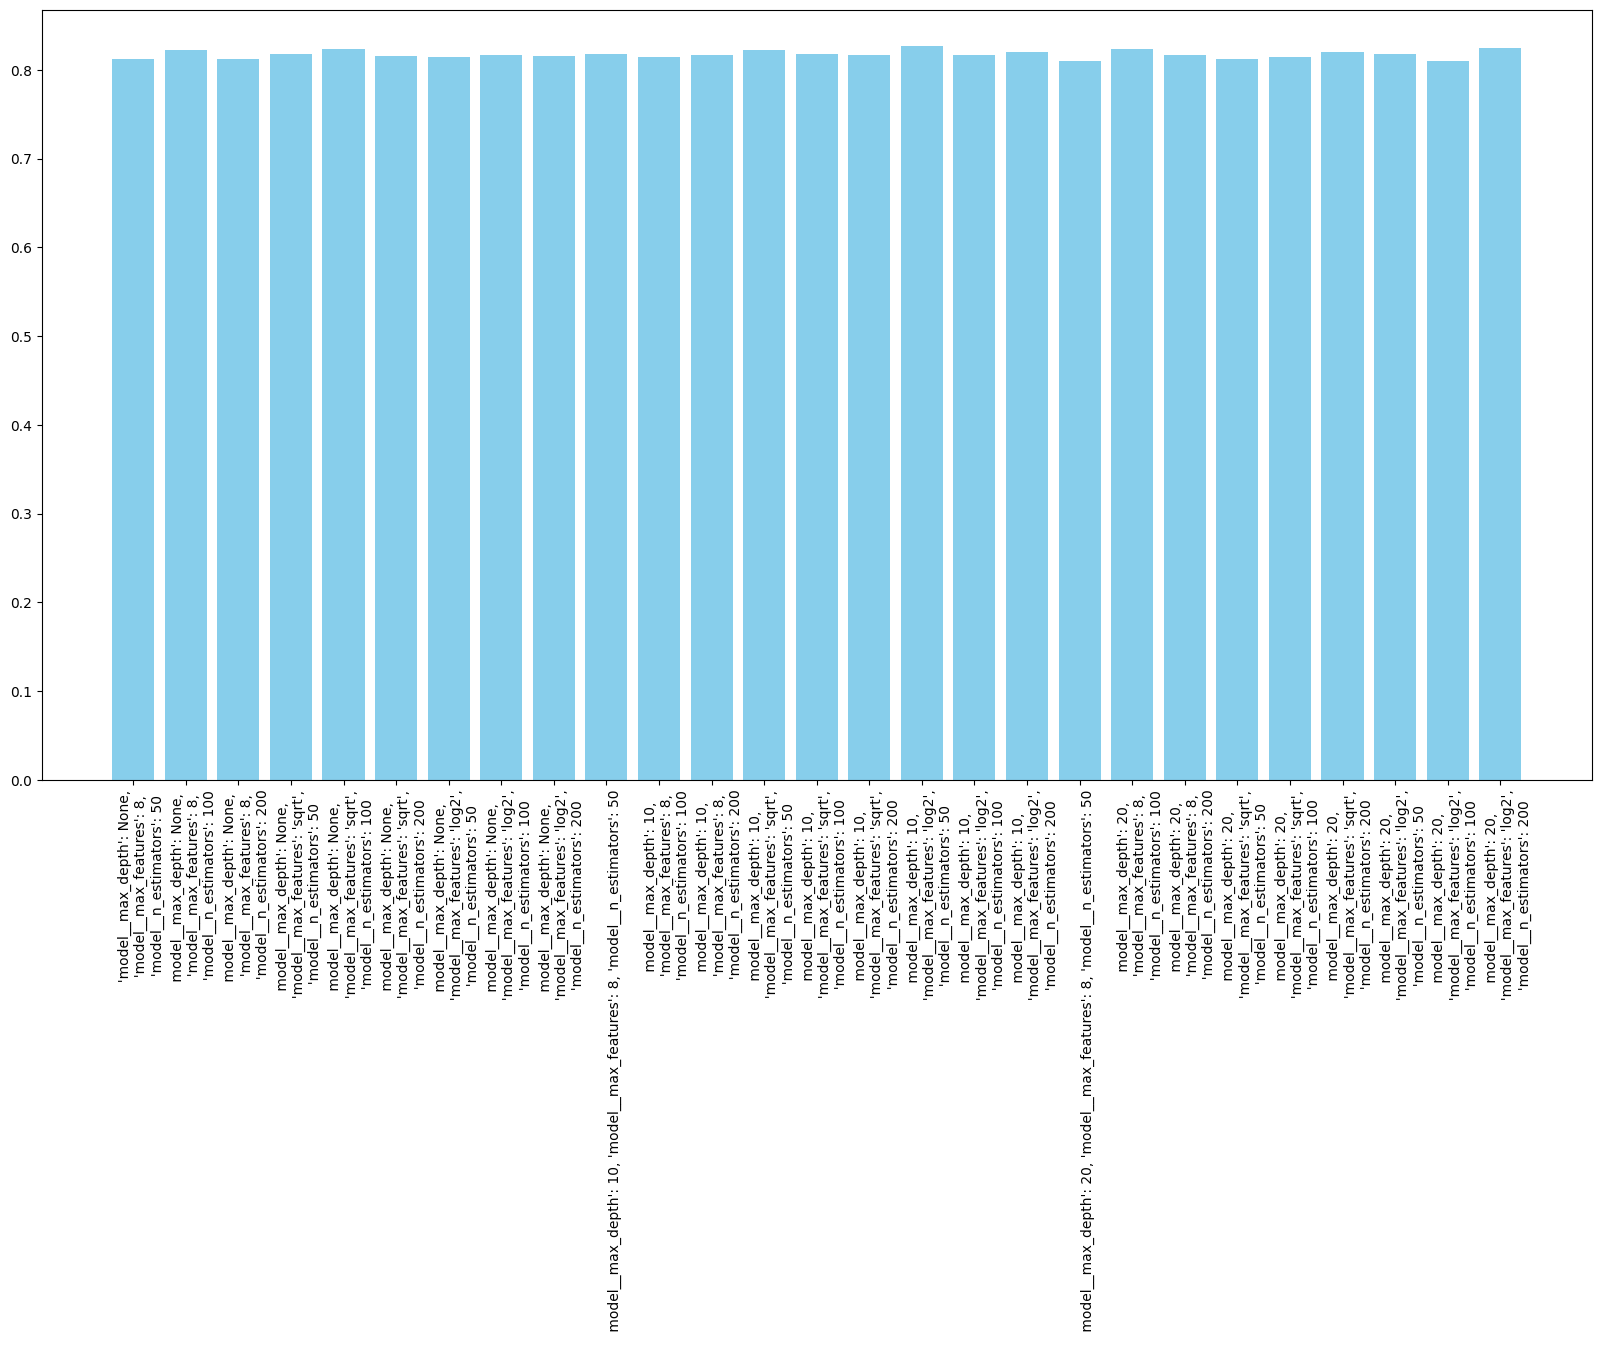

In [62]:
plt.figure(figsize=(20, 10))
plt.bar(param_values, mean_test_scores, color='skyblue')
plt.xticks(rotation=90)  

In [159]:
# Print the best parameters and the best score
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation accuracy: {grid_search.best_score_:.4f}")

Best parameters: {'model__max_depth': 10, 'model__max_features': 'log2', 'model__n_estimators': 50}
Best cross-validation accuracy: 0.8265


## Trying three more ensembles

In [75]:
# Divide data into training and validation subsets
X_train, X_valid, y_train, y_valid = train_test_split(df.drop(["class"], axis=1), df["class"], train_size=0.7, test_size=0.3,random_state=0)

In [76]:
# Applying SMOTE to the training set
sm = SMOTE(random_state=42)
X_train, y_train = sm.fit_resample(X_train, y_train)

### Gradient boosting machines

In [79]:
my_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', GradientBoostingClassifier())
                             ])

In [80]:
my_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   MinMaxScaler())]),
                                                  Index(['time_pregnant_no', 'plasma_concentration', 'diastolic_blood_pressure',
       'triceps_skinfold_thickness', 'serum_insulin', 'bmi',
       'diabetes_pedigree', 'age'],
      dtype='object'))])),
                ('model', GradientBoostingClassifier())])

In [81]:
y_pred = my_pipeline.predict(X_valid)

In [82]:
accuracy_score(y_valid, y_pred)

0.7705627705627706

### Ada boost

In [83]:
my_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', AdaBoostClassifier())
                             ])

In [84]:
my_pipeline.fit(X_train, y_train)

c:\Users\Lenovo\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   MinMaxScaler())]),
                                                  Index(['time_pregnant_no', 'plasma_concentration', 'diastolic_blood_pressure',
       'triceps_skinfold_thickness', 'serum_insulin', 'bmi',
       'diabetes_pedigree', 'age'],
      dtype='object'))])),
                ('model', AdaBoostClassifier())])

In [85]:
y_pred = my_pipeline.predict(X_valid)

In [86]:
accuracy_score(y_valid, y_pred)

0.7489177489177489

### XGBoost 

In [188]:
my_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', # Initialize the XGBClassifier with specified hyperparameters
                                         XGBClassifier(
                                            objective='binary:logistic',
                                            n_estimators=500,         
                                            learning_rate=0.3,        
                                            max_depth=10,              
                                            min_child_weight=3,       
                                            gamma=0.2,               
                                            subsample=0.8,            
                                            colsample_bytree=0.8,     
                                            reg_lambda=0.5,             
                                            reg_alpha=0.5,            
                                            use_label_encoder=False,  
                                            eval_metric='auc',    
                                            device="cuda"
                                        ))
                             ])

In [189]:
# Define the parameter grid
param_grid = {
    'model__n_estimators': [100, 300, 500],
    'model__learning_rate': [0.01, 0.1, 0.2],
    'model__max_depth': [3, 5, None],
    'model__min_child_weight': [1, 3, 5],
    'model__gamma': [0, 0.1, 0.2],
    'model__subsample': [0.7, 0.8, 1.0],
    'model__colsample_bytree': [0.7, 0.8, 1.0],
    'model__reg_lambda': [1, 3, 5],
    'model__reg_alpha': [0, 0.1, 0.5]
}

In [190]:
# Set up the grid search with cross-validation
grid_search = GridSearchCV(estimator=my_pipeline, param_grid=param_grid, 
                           scoring='accuracy', cv=3, verbose=1, n_jobs=-1)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Print the best parameters and the best score
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation accuracy: {grid_search.best_score_:.4f}")


c:\Users\Lenovo\anaconda3\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
c:\Users\Lenovo\anaconda3\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Fitting 3 folds for each of 19683 candidates, totalling 59049 fits


KeyboardInterrupt: 

In [174]:
y_pred = my_pipeline.predict(X_valid)

In [175]:
accuracy_score(y_valid, y_pred)

0.7748917748917749